<a href="https://colab.research.google.com/github/subarnop/NLPseq2seq/blob/master/line2line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

# generate a sequence from a language model
def generate_seq(model, tokenizer, max_length, seed_text, n_words):
	in_text = seed_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		# pre-pad sequences to a fixed length
		encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		# predict probabilities for each word
		yhat = model.predict_classes(encoded, verbose=0)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text += ' ' + out_word
	return in_text

# source text
data = """ Jack and Jill went up the hill\n
		To fetch a pail of water\n
		Jack fell down and broke his crown\n
		And Jill came tumbling after\n """
# prepare the tokenizer on the source text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
# determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# create line-based sequences
sequences = list()
for line in data.split('\n'):
	encoded = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(encoded)):
		sequence = encoded[:i+1]
		sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))
# pad input sequences
max_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
print('Max Sequence Length: %d' % max_length)
# split into input and output elements
sequences = array(sequences)
X, y = sequences[:,:-1],sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
# define model
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=max_length-1))
model.add(LSTM(50))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())
# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(X, y, epochs=500, verbose=2)
# evaluate model
print(generate_seq(model, tokenizer, max_length-1, 'Jack', 4))
print(generate_seq(model, tokenizer, max_length-1, 'Jill', 4))

Vocabulary Size: 22
Total Sequences: 21
Max Sequence Length: 7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 6, 10)             220       
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dense_2 (Dense)              (None, 22)                1122      
Total params: 13,542
Trainable params: 13,542
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
 - 1s - loss: 3.0913 - acc: 0.0476
Epoch 2/500
 - 0s - loss: 3.0898 - acc: 0.0476
Epoch 3/500
 - 0s - loss: 3.0882 - acc: 0.0952
Epoch 4/500
 - 0s - loss: 3.0867 - acc: 0.0952
Epoch 5/500
 - 0s - loss: 3.0851 - acc: 0.0952
Epoch 6/500
 - 0s - loss: 3.0835 - acc: 0.0952
Epoch 7/500
 - 0s - loss: 3.0819 - acc: 0.0952
Epoch

In [3]:
print(history.history.keys())

dict_keys(['loss', 'acc'])


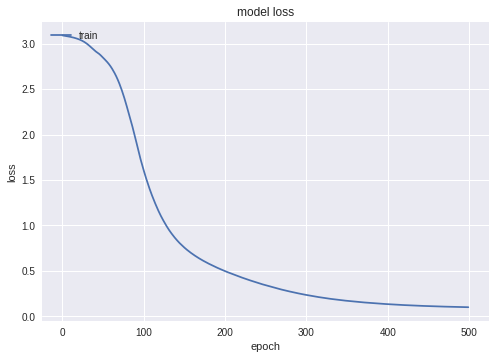

In [7]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
